In [1]:
import os, glob, random, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

random.seed(999)

# Paths
img_train_dir = f"../data/images/train"
img_val_dir   = f"../data/images/val"
label_train_dir = f"../data/labels/train"
label_val_dir = f"../data/labels/val"

images_train = sorted(glob.glob(f"{img_train_dir}/*.jpg", recursive=True))
images_test = sorted(glob.glob(f"{img_val_dir}/*.jpg", recursive = True))
labels_train = sorted(glob.glob(f"{label_train_dir}/*.txt", recursive=True))
labels_test = sorted(glob.glob(f"{label_val_dir}/*.txt", recursive = True))

print("# of training images:",len(images_train))
print("# of training labels:",len(labels_train))
print("# of testing images:",len(images_test))
print("# of testing labels:",len(labels_test))


# of training images: 18776
# of training labels: 18776
# of testing images: 7992
# of testing labels: 7992


In [2]:
#Check if there are any mismatched names
train_check, test_check = [], []

for i in range(len(images_train)):
    num1 = images_train[i].split('/')[-1].split('.')[0].split('_')[-1]
    num2 = labels_train[i].split('/')[-1].split('.')[0].split('_')[-1]
    train_check.append(num1 == num2)
if False in train_check:
    print("Stop. There are some mismatched names in training data")
else:
    print("Good to go(1/2)")

for i in range(len(images_test)):
    num1 = images_test[i].split('/')[-1].split('.')[0].split('_')[-1]
    num2 = labels_test[i].split('/')[-1].split('.')[0].split('_')[-1]
    test_check.append(num1 == num2)
if False in test_check:
    print("Stop. There are some mismatched names in training data")
else:
    print("Good to go(2/2)")
    
        

Good to go(1/2)
Good to go(2/2)


In [3]:
valid_numbers = random.sample(range(int(len(images_test))), int(len(images_test) / 2))
test_numbers = [i for i in range(len(images_test)) if i not in valid_numbers]

images_valid = sorted([images_test[i] for i in valid_numbers])
labels_valid = sorted([labels_test[i] for i in valid_numbers])

images_test = sorted([images_test[i] for i in test_numbers])
labels_test = sorted([labels_test[i] for i in test_numbers])

print(images_train)
print(labels_train)
print("\n")
print(images_valid)
print(labels_valid)
print("\n")
print(images_test)
print(labels_test)

['../data/images/train/IMG_00000001.jpg', '../data/images/train/IMG_00000006.jpg', '../data/images/train/IMG_00000007.jpg', '../data/images/train/IMG_00000008.jpg', '../data/images/train/IMG_00000010.jpg', '../data/images/train/IMG_00000011.jpg', '../data/images/train/IMG_00000012.jpg', '../data/images/train/IMG_00000013.jpg', '../data/images/train/IMG_00000014.jpg', '../data/images/train/IMG_00000015.jpg', '../data/images/train/IMG_00000016.jpg', '../data/images/train/IMG_00000019.jpg', '../data/images/train/IMG_00000020.jpg', '../data/images/train/IMG_00000022.jpg', '../data/images/train/IMG_00000025.jpg', '../data/images/train/IMG_00000026.jpg', '../data/images/train/IMG_00000027.jpg', '../data/images/train/IMG_00000028.jpg', '../data/images/train/IMG_00000029.jpg', '../data/images/train/IMG_00000030.jpg', '../data/images/train/IMG_00000031.jpg', '../data/images/train/IMG_00000032.jpg', '../data/images/train/IMG_00000033.jpg', '../data/images/train/IMG_00000035.jpg', '../data/images

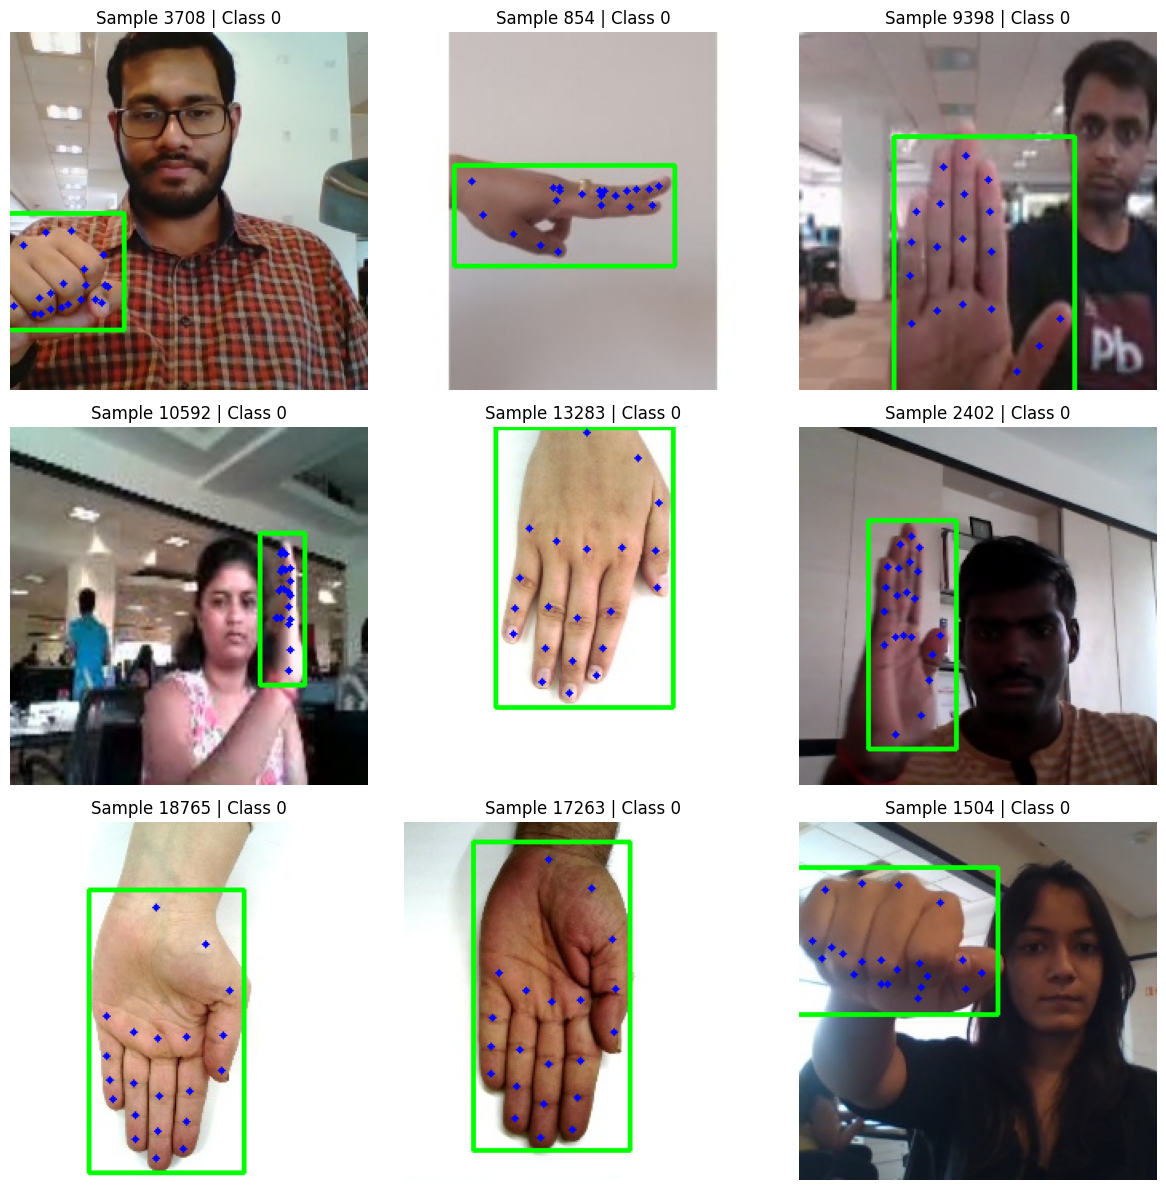

In [4]:
def draw_bbox(image_bgr, bbox_norm, img_w, img_h, color=(0, 255, 0)):
    cx, cy, bw, bh = bbox_norm
    x = int((cx - bw/2) * img_w)
    y = int((cy - bh/2) * img_h)
    w = int(bw * img_w)
    h = int(bh * img_h)
    out = image_bgr.copy()
    cv2.rectangle(out, (x, y), (x+w, y+h), color, 2)
    return out

def draw_keypoints(image_bgr, keypoints_norm, img_w, img_h, color=(255,0,0)):
    out = image_bgr.copy()
    keypoints = np.array(keypoints_norm).reshape(-1, 3)  # (21,3)

    for (x, y, v) in keypoints:
        if v > 0:
            px, py = int(round(x * img_w)), int(round(y * img_h))
            cv2.circle(out, (px, py), 2, color, -1)
    return out

# 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

# random number
sample_indices = random.sample(range(len(labels_train)), 9)

for idx, sample_num in enumerate(sample_indices):
    with open(labels_train[sample_num], "r", encoding="utf-8") as f:
        text = f.read()

    text_list = list(map(float, text.split()))
    obj_class = int(text_list[0])
    bbox = text_list[1:5]
    key_points = text_list[5:]

    # Ream images
    image = cv2.imread(images_train[sample_num])
    H, W = image.shape[:2]

    vis = draw_bbox(image, bbox, W, H)
    vis = draw_keypoints(vis, key_points, W, H)

    # subplot
    axes[idx].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f"Sample {sample_num} | Class {obj_class}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class HandDataset(Dataset):
    def __init__(self, images_list, labels_list, transform=transforms.ToTensor()):
        self.images_list = images_list
        self.labels_list = labels_list
        self.transform = transform
        
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        img_path = self.images_list[idx]
        label_path = self.labels_list[idx]
        
        image = Image.open(img_path).convert("RGB")
        W, H = image.size
        image = self.transform(image)
        
        with open(label_path, "r", encoding="utf-8") as f:
            text = f.read()
            
        vals = list(map(float, text.split()))
        
        #bbox
        cx, cy, bw, bh = vals[1:5] #cx,cy: box center | bw,bh: box w,h
        x1 = (cx - bw/2) * W
        y1 = (cy - bh/2) * H
        x2 = (cx + bw/2) * W
        y2 = (cy + bh/2) * H
        boxes = torch.tensor([[x1, y1, x2, y2]], dtype = torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)
        
        #keypoints
        kpts = vals[5:]
        kpts = np.array(kpts).reshape(-1,3)
        kpts[:,0] *= W
        kpts[:,1] *= H
        keypoints = torch.tensor(kpts, dtype=torch.float32).unsqueeze(0) # (N, K=21, 3)
        
        target = {"boxes": boxes,
                  "labels": labels,
                  "keypoints": keypoints}
        
        return image, target
    
def collate_fn(batch): #torchvision detection model expects list format
    images, targets = list(zip(*batch))   # unzip
    return list(images), list(targets)



In [6]:
from torch.utils.data import DataLoader

train_dataset = HandDataset(images_train, labels_train)
valid_dataset = HandDataset(images_valid, labels_valid)
test_dataset = HandDataset(images_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [11]:
print(len(train_loader))

18776


In [7]:
for images, targets in train_loader:
    print(len(images))        # 4
    print(targets[0].keys())  # dict: 'boxes', 'labels'
    print(targets[0]["boxes"])
    break

1
dict_keys(['boxes', 'labels', 'keypoints'])
tensor([[ 55.,   2., 166., 213.]])


In [8]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

DEVICE = "mps" if torch.backends.mps.is_available else "cpu"
print("device: ", DEVICE)

def build_hand_detector():
    model = fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, 2)
    return model.to(DEVICE)

model = build_hand_detector()

device:  mps


In [9]:
import torch.optim as optim

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

EPOCHS = 5  # 먼저 작게
for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for step, (images, targets) in enumerate(train_loader, 1):
        images  = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()
        if step % 20 == 0:
            print(f"[Ep {epoch} | {step}] total={loss.item():.4f} "
                  + " ".join([f"{k}={v.item():.3f}" for k,v in loss_dict.items()]))
                                                                         
    print(f"Epoch {epoch} train loss avg: {running/max(1,step):.4f}")


[Ep 1 | 20] total=0.8755 loss_classifier=0.338 loss_box_reg=0.526 loss_objectness=0.011 loss_rpn_box_reg=0.000
[Ep 1 | 40] total=0.3476 loss_classifier=0.120 loss_box_reg=0.215 loss_objectness=0.011 loss_rpn_box_reg=0.003
[Ep 1 | 60] total=0.4329 loss_classifier=0.218 loss_box_reg=0.155 loss_objectness=0.047 loss_rpn_box_reg=0.012
[Ep 1 | 80] total=1.5060 loss_classifier=0.221 loss_box_reg=1.282 loss_objectness=0.001 loss_rpn_box_reg=0.002
[Ep 1 | 100] total=1.1176 loss_classifier=0.397 loss_box_reg=0.718 loss_objectness=0.001 loss_rpn_box_reg=0.001
[Ep 1 | 120] total=1.1513 loss_classifier=0.255 loss_box_reg=0.895 loss_objectness=0.001 loss_rpn_box_reg=0.001
[Ep 1 | 140] total=1.5856 loss_classifier=0.431 loss_box_reg=1.153 loss_objectness=0.000 loss_rpn_box_reg=0.002
[Ep 1 | 160] total=0.5599 loss_classifier=0.208 loss_box_reg=0.272 loss_objectness=0.078 loss_rpn_box_reg=0.001
[Ep 1 | 180] total=0.8925 loss_classifier=0.172 loss_box_reg=0.719 loss_objectness=0.001 loss_rpn_box_reg=0.

KeyboardInterrupt: 

In [12]:
import gc, torch, os
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()